In [1]:
# type your code here
# type your code here
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import optimize
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# import various functions from statsmodel to perform linear regression
import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse

# import various functions from scipy
from scipy import stats
from scipy.stats import shapiro

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# import function to perform linear regression
from sklearn.linear_model import LinearRegression


# import functions to perform feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE

import datetime

In [2]:
bikeData = pd.read_csv('SeoulBikeData.csv')

In [3]:
bikeData.head(5)

,Date,Rented Bike Count,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
bikeData.describe(include='object')

,Date,Seasons,Holiday,Functioning Day
count,8760,8760,8760,8760
unique,365,4,2,2
top,16/02/2018,Summer,No Holiday,Yes
freq,24,2208,8328,8465


In [5]:
bikeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(�C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(�C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [6]:
bikeData['Hour'].describe()

count    8760.000000
mean       11.500000
std         6.922582
min         0.000000
25%         5.750000
50%        11.500000
75%        17.250000
max        23.000000
Name: Hour, dtype: float64

Hour can be treated as categorical than a numeric.

### 1.1 Utility Functions

#### Convert hour into 3 buckets

In [4]:
def convertHourBuckets(hour):
    hour = int(hour)
    if hour < 10:
        return 'morning'
    elif hour < 18:
        return 'day'
    else:
        return 'night'

In [5]:
# Convert a date in the format 12/09/2018 to corresponding day = "Wednesday"
def convertDate2Day(date):
    return datetime.datetime.strptime(date, '%d/%m/%Y').strftime('%A')

# Convert a date in the format 12/09/2018 to weekday or weekend if weekend returns 1
# did not consider the middle east standard, as the data is from Korea
def convertDate2Weekend(date):
    day = convertDate2Day(date)
    if day in ["Sunday","Saturday"]:
        return 1
    return 0

#### Scaling all together

In [104]:
def standardScale_dataframe(data,name_suffix = "_std"):
    std_scale = StandardScaler()
    variables = []
    numeric_df = data.select_dtypes(include=[np.number])
    for param in numeric_df.columns:
        param_name = param.strip()+name_suffix
        variables.append(param_name)
        if param_name not in (numeric_df.columns):
            print(param_name)
            numeric_df[param_name] = std_scale.fit_transform(data[[param]]) # returns z-scores of the values of the attribute
    return numeric_df,variables


#### Model Performance logged into a dataframe for comparison

In [46]:
# define a function to calculate MAPE
# pass the actual and predicted values as input to the function
# return the calculated MAPE 
def mape(actual, predicted):
    mape = np.abs((actual - predicted) / actual)
    mape = mape[~np.isnan(mape)]
    return ((mape) * 100).mean()

def model_metrics(result_df,model,name,remarks,datatype,y,y_hat):

    # calculate R-squared, Adjusted R-squared, MSE, RMSE, MAE and MAPE for full model
    # use 'rsquared' to calculate R-squared value
    # use 'rsquared_adj' to calculate Adjusted R-squared value
    # use 'mean_squared_error' to calculate MSE
    # use 'rmse' to calculate RMSE
    # use 'mean_absolute_error' to calculate MAE
    # use the defined function 'mape' to calculate MAPE
    residuals = model.resid

    MLR_full_model_metrics = pd.Series({'Model_Name': name,
                                        'Data_Type': datatype,
                                        'Remarks': remarks,
                                        'R-squared': model.rsquared,
                                        'Adj. R-squared': model.rsquared_adj,
                                        'Durbin_Watson':statsmodels.stats.stattools.durbin_watson(residuals, axis=0),
                                        'JB_Prob':statsmodels.stats.stattools.jarque_bera(residuals, axis=0)[1],
                                        'Condition_No': model.condition_number,
                                        'MSE': mean_squared_error(y, y_hat),
                                        'RMSE': np.sqrt(mean_squared_error(y, y_hat)),
                                        'MAE': mean_absolute_error(y, y_hat),
                                       })

    
    # append the values to the result table
    result_df = result_df[(result_df.Model_Name != name)]
    result_df = result_df.append(MLR_full_model_metrics, ignore_index = True)

    return result_df

In [15]:
#Utility function which wraps repeatedly used stuff for lr Models

In [69]:
def lr_model_experiment(df,target,exp_name,remarks,result_df,test_size=0.3,random_state = 123):
    X = df
    X = sm.add_constant(X)
    X = X.drop(target,axis = 1)
    print(X.columns)
    Y = df[target]
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=test_size,random_state=random_state) 
    lin_reg_model = sm.OLS(y_train,x_train).fit()
    
    y_test_predict = lin_reg_model.predict(x_test)

    out_df = model_metrics(result_df,lin_reg_model,exp_name+'_Test',remarks,"Test",y_test,y_test_predict)
    
    y_train_predict = lin_reg_model.predict(x_train)

    out_df = model_metrics(out_df,lin_reg_model,exp_name+'_Train',remarks,"Train",y_train,y_train_predict)
    return out_df,lin_reg_model,len(x_train)

### 1.2 Categorical Variables

In [8]:
#Convert the Hours into 3 buckets
bikeData['Hour_bkt'] = bikeData['Hour'].apply(lambda x : convertHourBuckets(x))

In [9]:
#Convert the Hours into 3 buckets
bikeData['Weekend'] = bikeData['Date'].apply(lambda x : convertDate2Weekend(x))

In [13]:
bikeData.Hour_bkt.unique()

array(['morning', 'day', 'night'], dtype=object)

In [10]:
#do the n-1 dummy encoding
bikeCatData_enc = pd.get_dummies(bikeData[['Seasons','Hour_bkt','Functioning Day','Holiday']],'',drop_first=True)
bikeCatData_enc.rename(columns={'_Yes':'FunctionDay'},inplace=True)
bikeCatData_enc.head(2)

,_Spring,_Summer,_Winter,_morning,_night,FunctionDay,_No Holiday
0,0,0,1,1,0,1,1
1,0,0,1,1,0,1,1


### 1.3 Take out all numbers

In [12]:
bikeData_num = bikeData.select_dtypes(include=[np.number])
bikeData_num = bikeData_num.drop('Hour',axis = 1)

In [13]:
bikeData_feats = pd.concat([bikeData_num,bikeCatData_enc], axis=1)

In [14]:
bikeData_feats.describe()

,Rented Bike Count,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Weekend,_Spring,_Summer,_Winter,_morning,_night,FunctionDay,_No Holiday
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,0.284932,0.252055,0.252055,0.246575,0.416667,0.250000,0.966324,0.950685
std,644.997468,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,0.451408,0.434217,0.434217,0.431042,0.493035,0.433037,0.180404,0.216537
min,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,191.000000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,504.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.250000,1.000000,1.000000
max,3556.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3. Multiple Linear Regression(MLR)

### 3.1 Understanding the Features Relations

<Figure size 1080x1080 with 0 Axes>

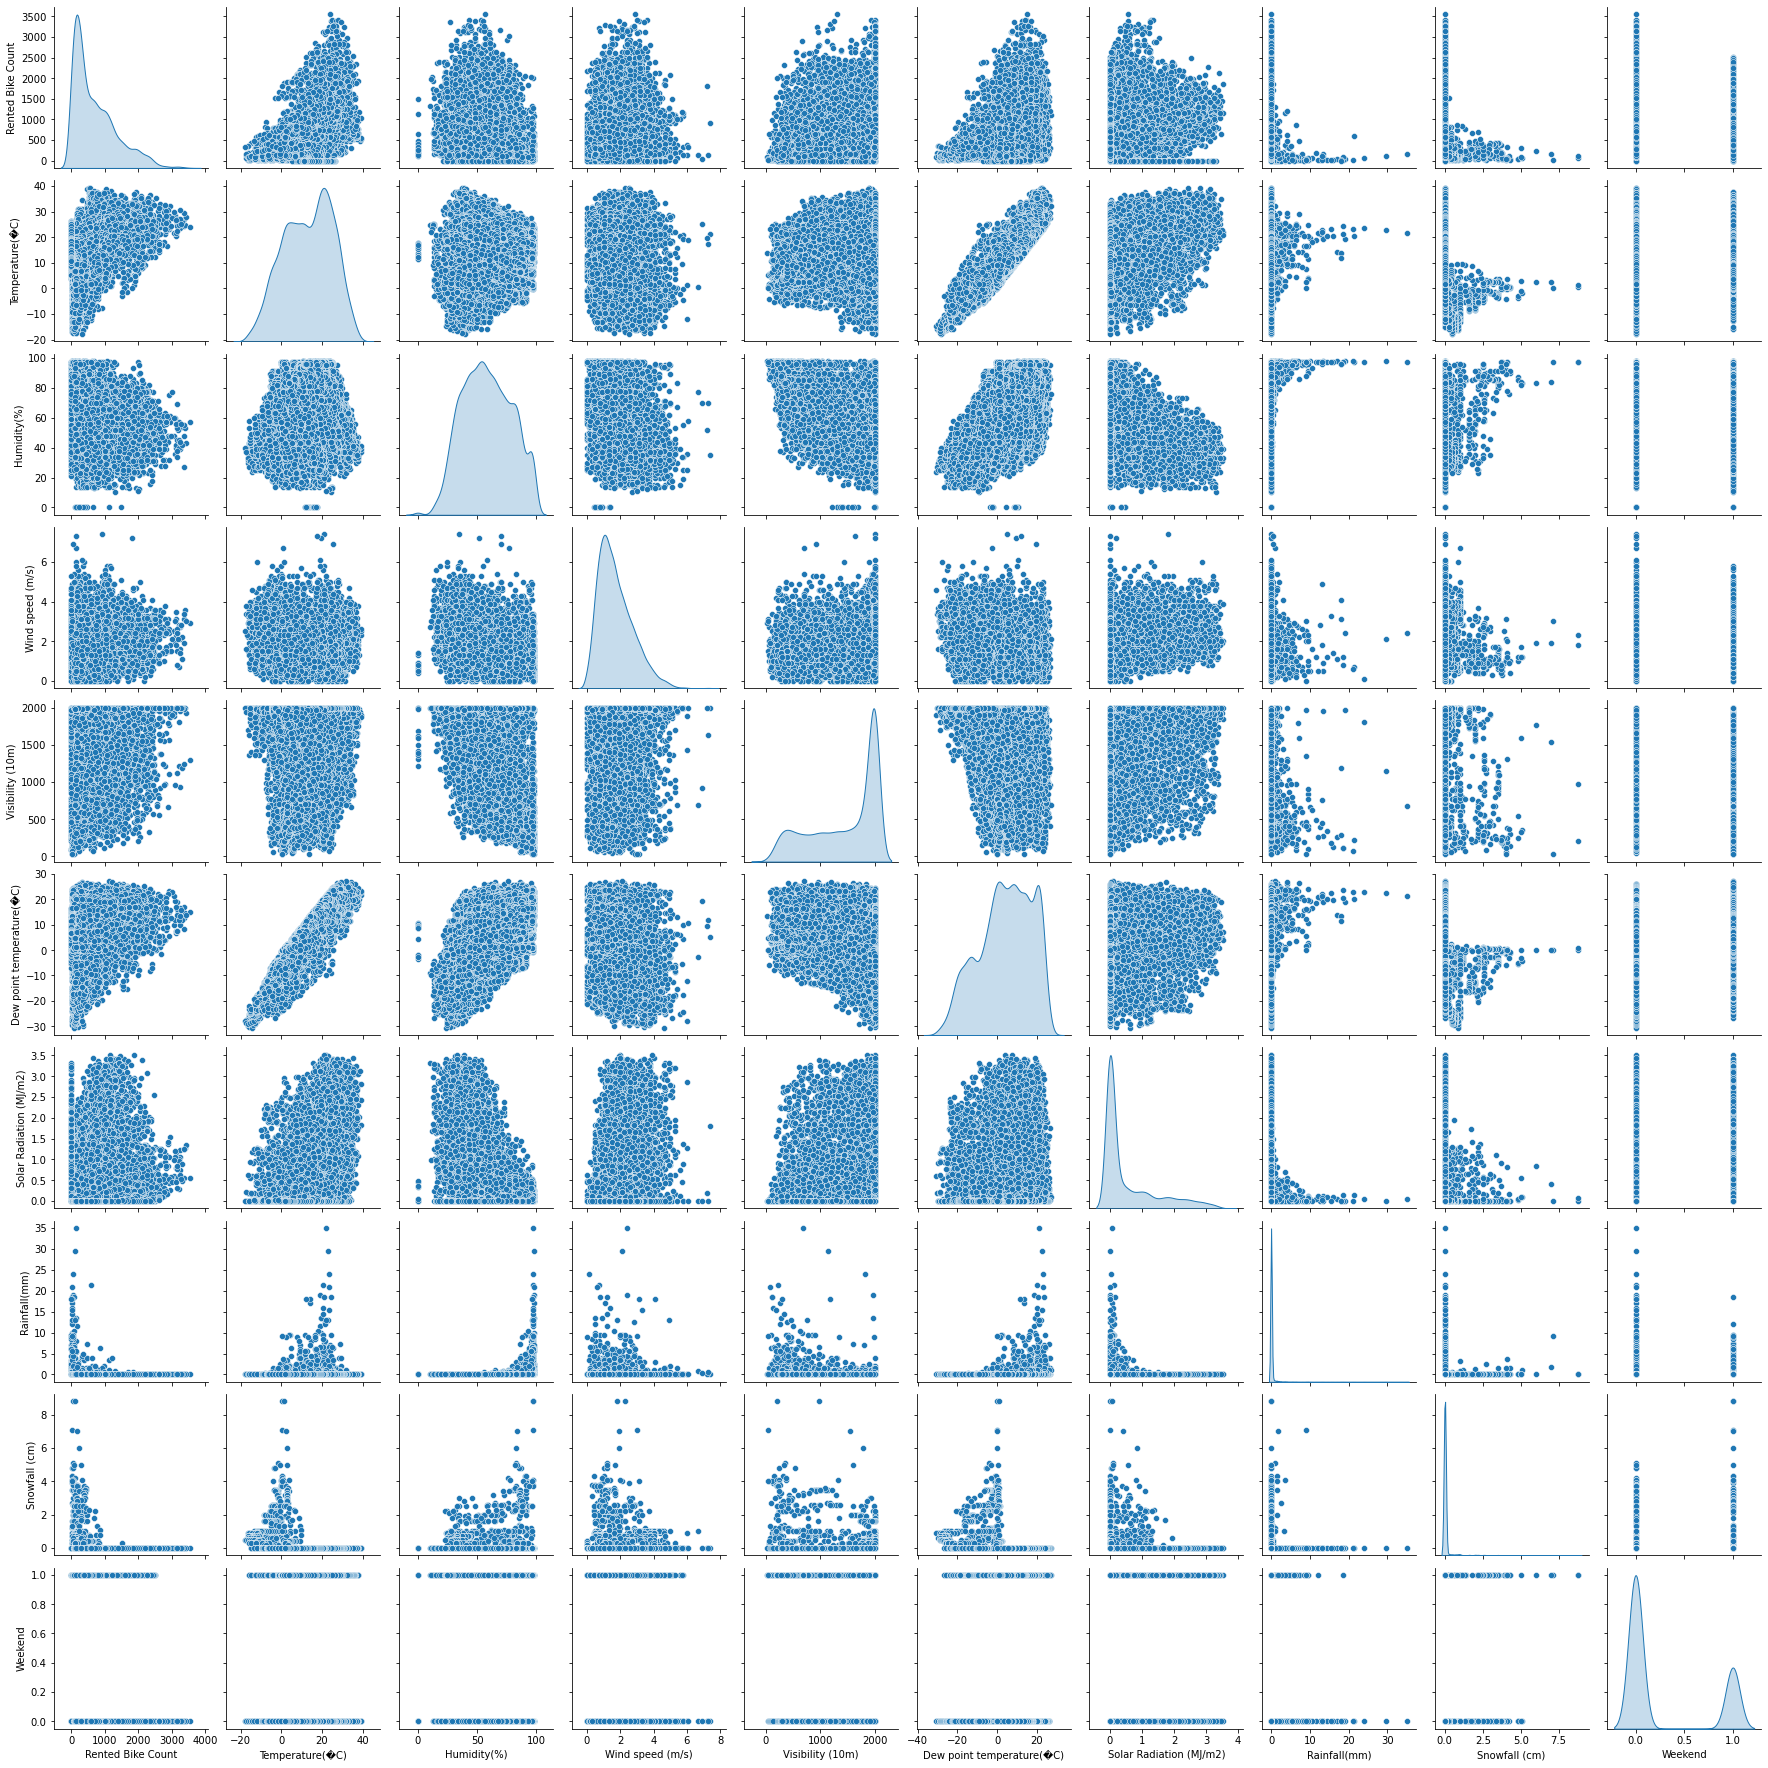

In [18]:
plt.figure(figsize=(15,15))
sns.pairplot(bikeData_num, diag_kind="kde")
#g.map_lower(sns.kdeplot, levels=4, color=".2")

**Observation1: some linearity is identified between Temperature and Dew point temperature**

In [61]:
corr = bikeData_feats.corr()


2.8318422417365957e-05

<AxesSubplot:>

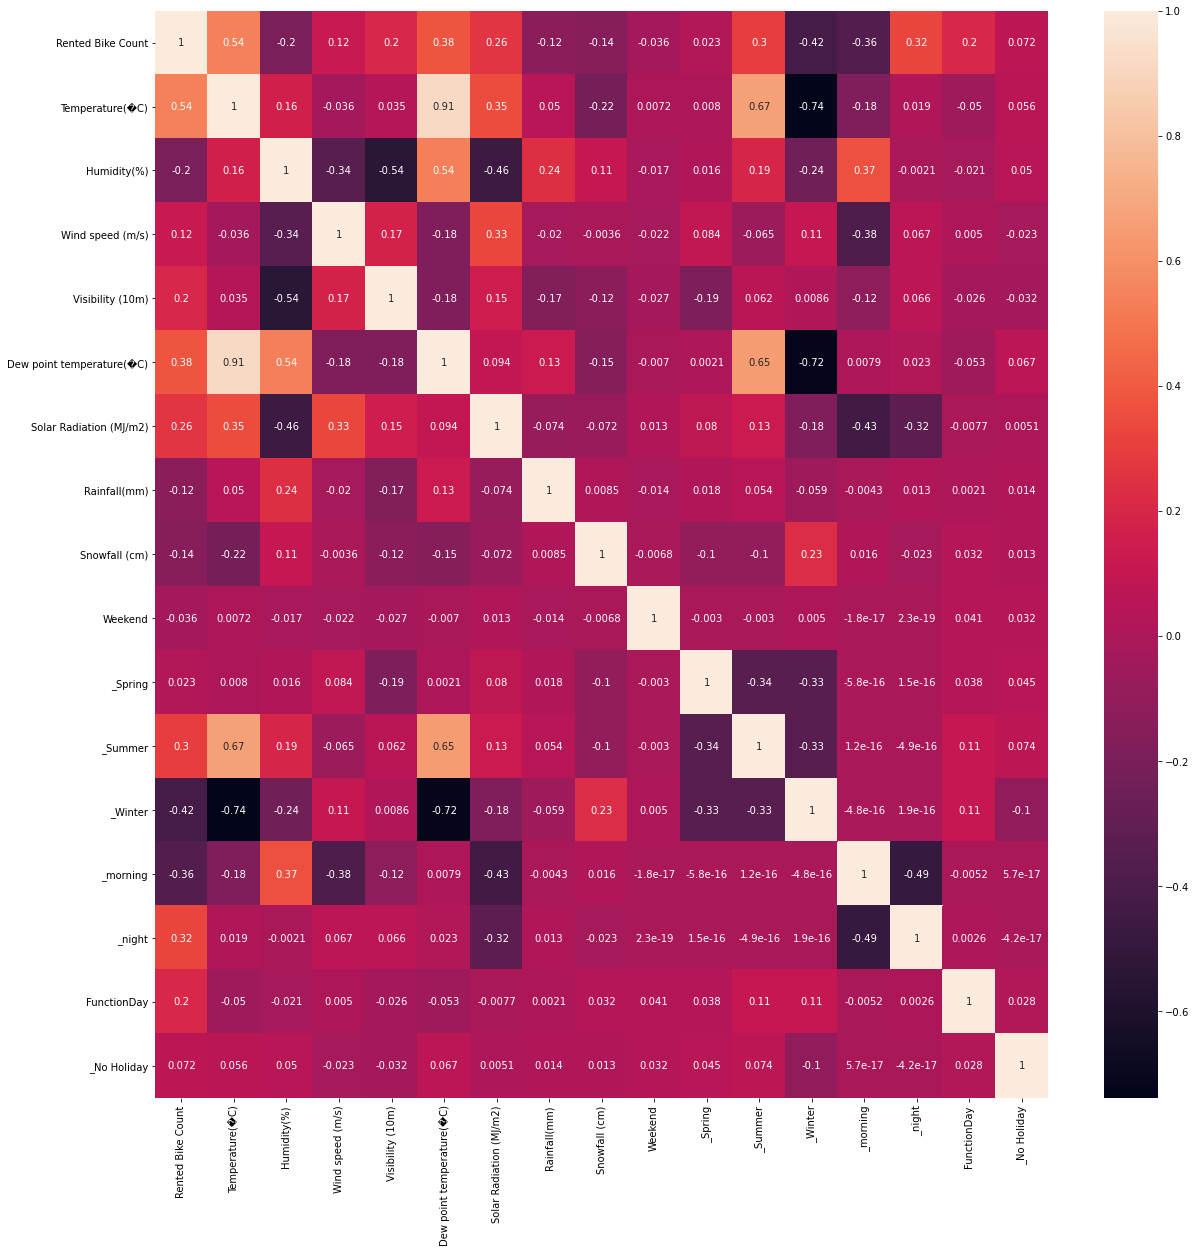

In [20]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True)

<AxesSubplot:>

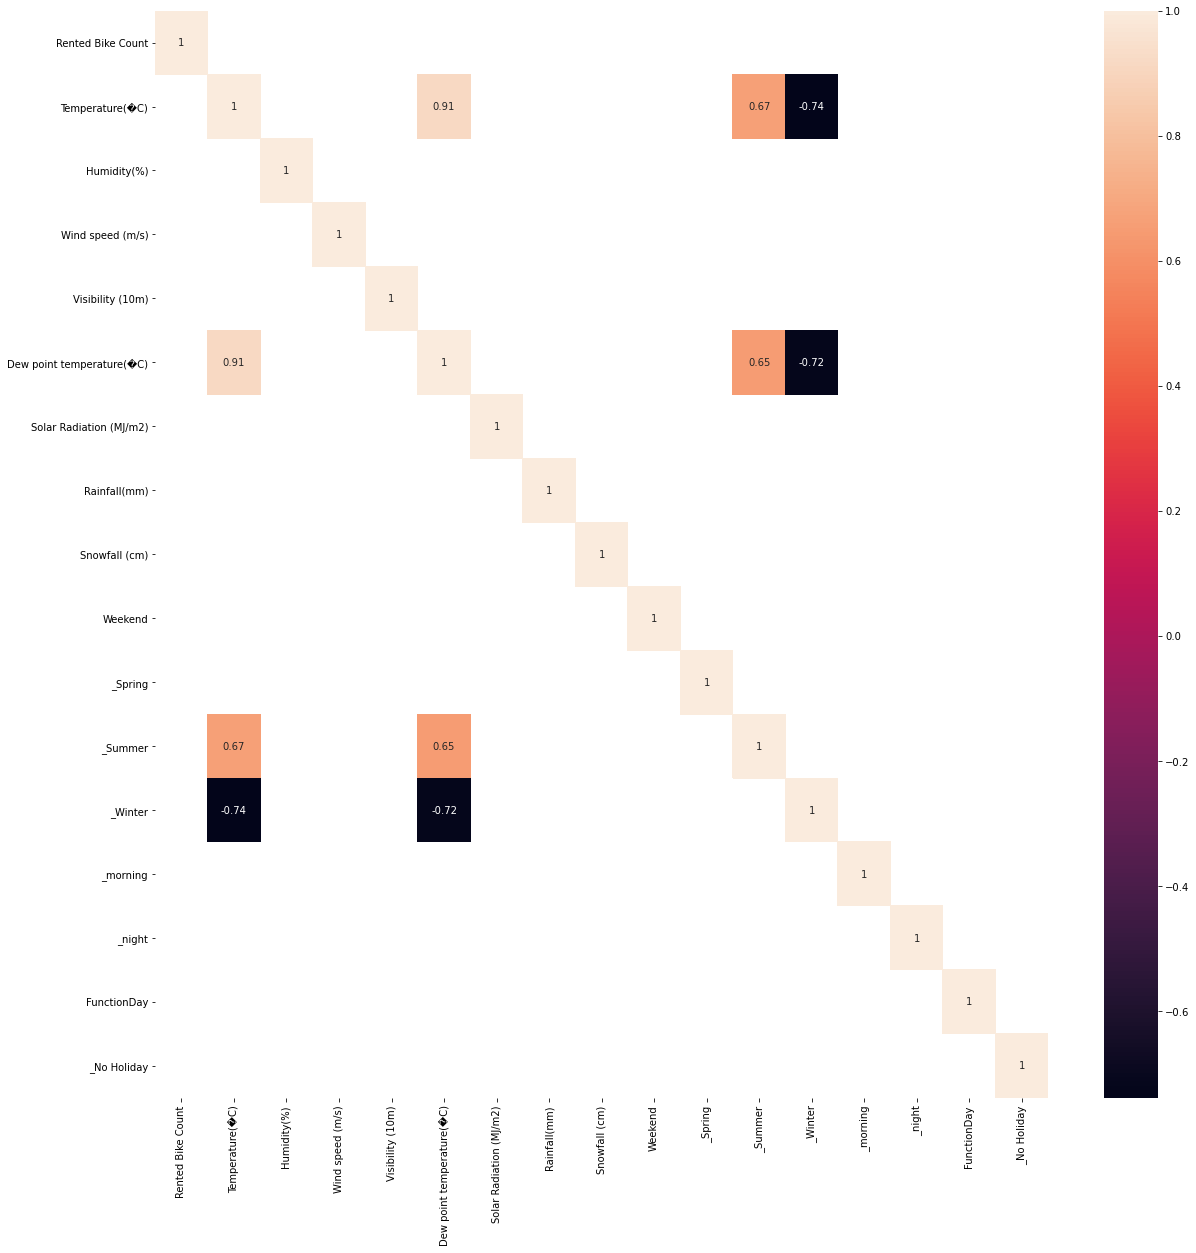

In [24]:
filter_corr = corr[np.abs(corr) > 0.6]
plt.figure(figsize=(20,20))
sns.heatmap(filter_corr, annot=True)

**Observation2: Significant linearity is identified between Temperature with Summer and Winter**

### 3.2 Model Building

In [26]:
Model_Features = list(bikeData_feats.columns)
Model_Features

['Rented Bike Count',
 'Temperature(�C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(�C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Weekend',
 '_Spring',
 '_Summer',
 '_Winter',
 '_morning',
 '_night',
 'FunctionDay',
 '_No Holiday']

In [27]:
Target_Variable = ['Rented Bike Count']

**Make a result dataframe**

In [72]:
#Model Parameters to be compared in each experiments
cols = ['Model_Name','Data_Type','Remarks', 
        'R-squared','Adj. R-squared', 
        'Durbin_Watson', 'JB_Prob', 'Condition_No',
        'MSE', 'RMSE', 'MAE']
# creating a empty dataframe of the colums
result_table_e3_set = pd.DataFrame(columns = cols)

In [73]:
# Fit the Model and store the results
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats,Target_Variable,"BIKE_LR_ALL_E31",
                                                              "All variables, no tranformation,\
                                                               no scaling, only categorical encoding",
                                                               result_table_e3_set,0.3,123)


Index(['const', 'Temperature(�C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Weekend',
       '_Spring', '_Summer', '_Winter', '_morning', '_night', 'FunctionDay',
       '_No Holiday'],
      dtype='object')


In [74]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     506.1
Date:                Wed, 15 Sep 2021   Prob (F-statistic):               0.00
Time:                        06:29:53   Log-Likelihood:                -45826.
No. Observations:                6132   AIC:                         9.169e+04
Df Residuals:                    6115   BIC:                         9.180e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      -153.6431    118.968     -1.291      0.197    -386.863      79.576
Temperature(�C)              24.0391      4.389      5.477      0.000      15.435      32.643
Humidity(%)                  -9.4493      1.230     -7.681      0.000     -11.861      -7.038
Wind speed (m/s)             33.9549      6.105      5.562      0.000      21.987      45.923
Visibility (10m)             -0.0150      0.012     -1.279      0.201      -0.038       0.008
Dew point temperature(�C)     4.1801      4.591      0.910      0.363      -4.821      13.181
Solar Radiation (MJ/m2)      53.6498     11.617      4.618      0.000      30.876      76.424
Rainfall(mm)                -48.6234      4.759    -10.217      0.000     -57.953     -39.294
Snowfall (cm)                35.5572     13.469      2.640      0.008       9.154      61.961
Weekend                     -84.5986     12.134     -6.972      0.000    -108.386     -60.811
_Spring                    -177.1269     16.420    -10.787      0.000    -209.316    -144.938
_Summer                    -204.0067     20.345    -10.027      0.000    -243.890    -164.123
_Winter                    -323.4542     23.313    -13.875      0.000    -369.155    -277.753
_morning                     63.6994     19.283      3.303      0.001      25.897     101.501
_night                      545.8137     20.327     26.852      0.000     505.966     585.661
FunctionDay                 960.0229     31.939     30.058      0.000     897.411    1022.635
_No Holiday                 139.2428     25.424      5.477      0.000      89.403     189.082
==============================================================================
Omnibus:                      816.820   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1438.526
Skew:                           0.879   Prob(JB):                         0.00
Kurtosis:                       4.594   Cond. No.                     3.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [75]:
result_table_e3_set.tail()

,Model_Name,Data_Type,Remarks,R-squared,Adj. R-squared,Durbin_Watson,JB_Prob,Condition_No,MSE,RMSE,MAE
0,BIKE_LR_ALL_E31_Test,Test,"All variables, no tranformation, ...",0.56975,0.568624,2.013302,0.0,34174.968769,181567.614085,426.107515,324.733638
1,BIKE_LR_ALL_E31_Train,Train,"All variables, no tranformation, ...",0.56975,0.568624,2.013302,0.0,34174.968769,181442.188242,425.960313,317.537365


### 3.3 Model Evaluation

#### 3.3.1 Determinant of correlaton Matrix

***Let D be the determinant of correlation matrix. \
Then 0 < D < 1\
D=0 High multicollinearity\
D=1 No multicollinearit***

In [76]:
bikeData_feats_noTarget = bikeData_feats.drop(Target_Variable,axis=1)
np.linalg.det(bikeData_feats_noTarget.corr())

6.496290089494952e-05

#### 3.3.2 Condition Number

***CN > 1000 Severe multicollinearity\
100 < CN < 1000 Moderate multicollinearity\
100 < CN No multicollinearity***

In [67]:
print("Condition Number is very High = ",lr_model.condition_number)

Condition Number is very High =  34174.96876942314


#### Experiment 2

Reduce some features which are shown as linear from the heatmap

In [77]:
bikeData_feats_e32 = bikeData_feats.drop(['_Summer', '_Winter','Dew point temperature(�C)'],axis=1)

In [86]:
# Fit the Model and store the results
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats_e32,Target_Variable,"BIKE_LR_ALL_E32",
                                                              "Base = BIKE_LR_ALL_E32,\
                                                               Removed high correlations",
                                                               result_table_e3_set,0.3,123)

Index(['const', 'Temperature(�C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)',
       'Snowfall (cm)', 'Weekend', '_Spring', '_morning', '_night',
       'FunctionDay', '_No Holiday'],
      dtype='object')


In [87]:
result_table_e3_set.tail()

,Model_Name,Data_Type,Remarks,R-squared,Adj. R-squared,Durbin_Watson,JB_Prob,Condition_No,MSE,RMSE,MAE
0,BIKE_LR_ALL_E31_Test,Test,"All variables, no tranformation, ...",0.569750,0.568624,2.013302,0.000000e+00,34174.968769,181567.614085,426.107515,324.733638
1,BIKE_LR_ALL_E31_Train,Train,"All variables, no tranformation, ...",0.569750,0.568624,2.013302,0.000000e+00,34174.968769,181442.188242,425.960313,317.537365
2,BIKE_LR_ALL_E32_Test,Test,"Base = BIKE_LR_ALL_E32, ...",0.545204,0.544238,2.009292,9.954178e-294,17133.796207,193099.616332,439.431014,331.241346
3,BIKE_LR_ALL_E32_Train,Train,"Base = BIKE_LR_ALL_E32, ...",0.545204,0.544238,2.009292,9.954178e-294,17133.796207,191793.549980,437.942405,324.923807


<AxesSubplot:>

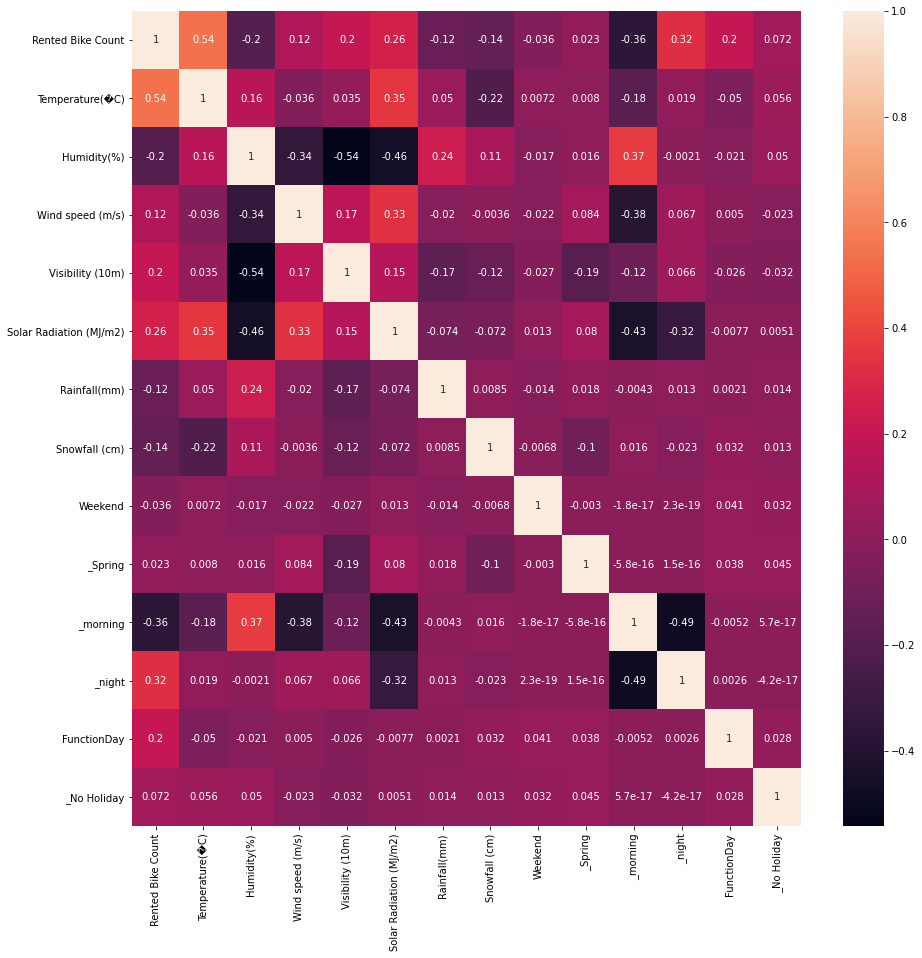

In [82]:
plt.figure(figsize=(15,15))
sns.heatmap(bikeData_feats_e32.corr(),annot=True)

#### Experiment 3

Reduce some more  features which are showing linearity near to 5

In [85]:
bikeData_feats_e33 = bikeData_feats.drop(['_Summer', '_Winter',\
                                          'Dew point temperature(�C)',\
                                          'Humidity(%)','_night'],axis=1)

In [113]:
# Fit the Model and store the results
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats_e32,Target_Variable,"BIKE_LR_ALL_E33",
                                                              "Removed correlation near to |0.5|,\
                                                               base BIKE_LR_ALL_E32",
                                                               result_table_e3_set,0.3,123)

Index(['const', 'Temperature(�C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)',
       'Snowfall (cm)', 'Weekend', '_Spring', '_morning', '_night',
       'FunctionDay', '_No Holiday'],
      dtype='object')


In [89]:
result_table_e3_set.tail()

,Model_Name,Data_Type,Remarks,R-squared,Adj. R-squared,Durbin_Watson,JB_Prob,Condition_No,MSE,RMSE,MAE
1,BIKE_LR_ALL_E31_Train,Train,"All variables, no tranformation, ...",0.569750,0.568624,2.013302,0.000000e+00,34174.968769,181442.188242,425.960313,317.537365
2,BIKE_LR_ALL_E32_Test,Test,"Base = BIKE_LR_ALL_E32, ...",0.545204,0.544238,2.009292,9.954178e-294,17133.796207,193099.616332,439.431014,331.241346
3,BIKE_LR_ALL_E32_Train,Train,"Base = BIKE_LR_ALL_E32, ...",0.545204,0.544238,2.009292,9.954178e-294,17133.796207,191793.549980,437.942405,324.923807
4,BIKE_LR_ALL_E33_Test,Test,"Removed correlation near to |0.5|, ...",0.545204,0.544238,2.009292,9.954178e-294,17133.796207,193099.616332,439.431014,331.241346
5,BIKE_LR_ALL_E33_Train,Train,"Removed correlation near to |0.5|, ...",0.545204,0.544238,2.009292,9.954178e-294,17133.796207,191793.549980,437.942405,324.923807


***Observation: No Improvement has been observed from Experiment 32***

#### Experiment 4

Lets Scale the Data

In [105]:
bikeData_feats_e34,var_names = standardScale_dataframe(bikeData_feats)

Rented Bike Count_std
Temperature(�C)_std
Humidity(%)_std
Wind speed (m/s)_std
Visibility (10m)_std
Dew point temperature(�C)_std
Solar Radiation (MJ/m2)_std
Rainfall(mm)_std
Snowfall (cm)_std
Weekend_std
_Spring_std
_Summer_std
_Winter_std
_morning_std
_night_std
FunctionDay_std
_No Holiday_std


In [108]:
bikeData_feats_e34_std = bikeData_feats_e34[var_names]


,Rented Bike Count_std,Temperature(�C)_std,Humidity(%)_std,Wind speed (m/s)_std,Visibility (10m)_std,Dew point temperature(�C)_std,Solar Radiation (MJ/m2)_std,Rainfall(mm)_std,Snowfall (cm)_std,Weekend_std,_Spring_std,_Summer_std,_Winter_std,_morning_std,_night_std,FunctionDay_std,_No Holiday_std
0,-0.698650,-1.513957,-1.042483,0.458476,0.925871,-1.659605,-0.655132,-0.1318,-0.171891,-0.631243,-0.580514,-0.580514,1.748015,1.183216,-0.577350,0.18668,0.227757
1,-0.776175,-1.539074,-0.993370,-0.892561,0.925871,-1.659605,-0.655132,-0.1318,-0.171891,-0.631243,-0.580514,-0.580514,1.748015,1.183216,-0.577350,0.18668,0.227757
2,-0.824240,-1.580936,-0.944257,-0.699556,0.925871,-1.667262,-0.655132,-0.1318,-0.171891,-0.631243,-0.580514,-0.580514,1.748015,1.183216,-0.577350,0.18668,0.227757
3,-0.926571,-1.597680,-0.895144,-0.796059,0.925871,-1.659605,-0.655132,-0.1318,-0.171891,-0.631243,-0.580514,-0.580514,1.748015,1.183216,-0.577350,0.18668,0.227757
4,-0.971535,-1.580936,-1.091596,0.554978,0.925871,-1.736177,-0.655132,-0.1318,-0.171891,-0.631243,-0.580514,-0.580514,1.748015,1.183216,-0.577350,0.18668,0.227757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.462661,-0.726961,-1.189822,0.844486,0.751605,-1.100630,-0.655132,-0.1318,-0.171891,-0.631243,-0.580514,-0.580514,-0.572078,-0.845154,1.732051,0.18668,0.227757
8756,0.092095,-0.793939,-1.042483,0.554978,0.925871,-1.070001,-0.655132,-0.1318,-0.171891,-0.631243,-0.580514,-0.580514,-0.572078,-0.845154,1.732051,0.18668,0.227757
8757,-0.016438,-0.860918,-0.944257,-1.375075,0.873263,-1.070001,-0.655132,-0.1318,-0.171891,-0.631243,-0.580514,-0.580514,-0.572078,-0.845154,1.732051,0.18668,0.227757
8758,0.011470,-0.902779,-0.846031,-0.699556,0.694064,-1.062344,-0.655132,-0.1318,-0.171891,-0.631243,-0.580514,-0.580514,-0.572078,-0.845154,1.732051,0.18668,0.227757


In [114]:
# Fit the Model and store the results
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats_e34_std,['Rented Bike Count_std'],"BIKE_LR_ALL_E34",
                                                              "input and output variable scaled",
                                                               result_table_e3_set,0.3,123)

Index(['const', 'Temperature(�C)_std', 'Humidity(%)_std',
       'Wind speed (m/s)_std', 'Visibility (10m)_std',
       'Dew point temperature(�C)_std', 'Solar Radiation (MJ/m2)_std',
       'Rainfall(mm)_std', 'Snowfall (cm)_std', 'Weekend_std', '_Spring_std',
       '_Summer_std', '_Winter_std', '_morning_std', '_night_std',
       'FunctionDay_std', '_No Holiday_std'],
      dtype='object')


In [115]:
result_table_e3_set.tail()

,Model_Name,Data_Type,Remarks,R-squared,Adj. R-squared,Durbin_Watson,JB_Prob,Condition_No,MSE,RMSE,MAE
3,BIKE_LR_ALL_E32_Train,Train,"Base = BIKE_LR_ALL_E32, ...",0.545204,0.544238,2.009292,9.954178e-294,17133.796207,191793.549980,437.942405,324.923807
4,BIKE_LR_ALL_E33_Test,Test,"Removed correlation near to |0.5|, ...",0.545204,0.544238,2.009292,9.954178e-294,17133.796207,193099.616332,439.431014,331.241346
5,BIKE_LR_ALL_E33_Train,Train,"Removed correlation near to |0.5|, ...",0.545204,0.544238,2.009292,9.954178e-294,17133.796207,191793.549980,437.942405,324.923807
6,BIKE_LR_ALL_E34_Test,Test,input and output variable scaled,0.569750,0.568624,2.013302,0.000000e+00,27.523096,0.436488,0.660672,0.503494
7,BIKE_LR_ALL_E34_Train,Train,input and output variable scaled,0.569750,0.568624,2.013302,0.000000e+00,27.523096,0.436186,0.660444,0.492336


In [112]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Rented Bike Count_std   R-squared:                       0.570
Model:                               OLS   Adj. R-squared:                  0.569
Method:                    Least Squares   F-statistic:                     506.1
Date:                   Wed, 15 Sep 2021   Prob (F-statistic):               0.00
Time:                           08:15:16   Log-Likelihood:                -6157.1
No. Observations:                   6132   AIC:                         1.235e+04
Df Residuals:                       6115   BIC:                         1.246e+04
Df Model:                             16                                         
Covariance Type:               nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0069      0.008      0.814      0.416      -0.010       0.023
Temperature(�C)_std               0.4452      0.081      5.477      0.000       0.286       0.605
Humidity(%)_std                  -0.2983      0.039     -7.681      0.000      -0.374      -0.222
Wind speed (m/s)_std              0.0546      0.010      5.562      0.000       0.035       0.074
Visibility (10m)_std             -0.0141      0.011     -1.279      0.201      -0.036       0.008
Dew point temperature(�C)_std     0.0846      0.093      0.910      0.363      -0.098       0.267
Solar Radiation (MJ/m2)_std       0.0723      0.016      4.618      0.000       0.042       0.103
Rainfall(mm)_std                 -0.0850      0.008    -10.217      0.000      -0.101      -0.069
Snowfall (cm)_std                 0.0241      0.009      2.640      0.008       0.006       0.042
Weekend_std                      -0.0592      0.008     -6.972      0.000      -0.076      -0.043
_Spring_std                      -0.1192      0.011    -10.787      0.000      -0.141      -0.098
_Summer_std                      -0.1373      0.014    -10.027      0.000      -0.164      -0.110
_Winter_std                      -0.2162      0.016    -13.875      0.000      -0.247      -0.186
_morning_std                      0.0487      0.015      3.303      0.001       0.020       0.078
_night_std                        0.3664      0.014     26.852      0.000       0.340       0.393
FunctionDay_std                   0.2685      0.009     30.058      0.000       0.251       0.286
_No Holiday_std                   0.0467      0.009      5.477      0.000       0.030       0.063
==============================================================================
Omnibus:                      816.820   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1438.526
Skew:                           0.879   Prob(JB):                         0.00
Kurtosis:                       4.594   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""